# **Model and Evaluation**

## Objectives

* Create Train and Test set and Machine Learning Pipeline to answer the second business requirement which is:
    * The client is interested in predicting the house sale price from her four inherited houses and any other house in Ames, Iowa.

## Inputs

* The clean and feature engineered datasets are located at: outputs/dataset/collection

## Outputs

* Train set (features and target)* 
Test set (features and target
* Modeling Pipeline. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Fabrizio-Project-Five/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Fabrizio-Project-Five'

Before starting our model notebook we will create a cell where we will place all of our imports and we'll create a folder where to store the various results from this notebook

In [4]:
version = 'v1'
filepath = f'outputs/ml_pipeline/predict_saleprice/{version}'
try:
    os.makedirs(name=filepath)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
# ML imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Feature Selection
from sklearn.feature_selection import SelectFromModel
# Import GridSearchCV for model score evaluation
from sklearn.model_selection import GridSearchCV
# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
# metrics for model evaluation
from sklearn.metrics import r2_score

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Splitting the Dataset

In this section we will split the dataset in Train and Test set in order to prepare it for model training. The test set will be 20% of the whole dataset just to make sure we are adherent to ML initial best practices.

In [6]:
df_fe = pd.read_csv('outputs/dataset/collection/clean_dataset.csv')
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1379 non-null   int64  
 1   2ndFlrSF       1379 non-null   float64
 2   BedroomAbvGr   1379 non-null   float64
 3   BsmtExposure   1379 non-null   object 
 4   BsmtFinSF1     1379 non-null   int64  
 5   BsmtFinType1   1379 non-null   object 
 6   BsmtUnfSF      1379 non-null   int64  
 7   EnclosedPorch  1379 non-null   float64
 8   GarageArea     1379 non-null   int64  
 9   GarageFinish   1379 non-null   object 
 10  GarageYrBlt    1379 non-null   float64
 11  GrLivArea      1379 non-null   int64  
 12  KitchenQual    1379 non-null   object 
 13  LotArea        1379 non-null   int64  
 14  LotFrontage    1379 non-null   float64
 15  MasVnrArea     1379 non-null   float64
 16  OpenPorchSF    1379 non-null   int64  
 17  OverallCond    1379 non-null   int64  
 18  OverallQ

In [7]:
X = df_fe.drop('SalePrice', axis=1)
y = df_fe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1103, 23) (1103,) 
* Test set: (276, 23) (276,)


As we can see from the result of the .shape attribute called on the various test and train datasets we have achieved our goal. Now we can move on to the ML Pipeline itself.

---

# Regression Pipeline

In this section we will study which regression algorithm is the best one fo our ML business case. The results from the algorithm will also provide us with information that we can use to determine if additional hyperparameter optimization will be needed.

In this cell I have imported code from the Churnometer Walkthrough Project. These two dictionaries list first the type of regression
model we want to try for our ML business case and second a dictionary which will run a search for the default hyperparameters for each model

In [8]:
# Code from the Churnometer Walkthrough Project

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In the next cell I will import a custom class from the Churnometer Project. Specifically this class will fit all the models listed in the in the previous dictionary and will apply the default hyperparameters (again, as listed in the previous dictionary). The class will also return a DataFrame with the scores for the regression models. This will allow us to select the best model for our Business Case.

In [9]:
# Code from Churnometer Walkthrough Project
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = regression_pipeline(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In the next cell we will instantiate the Pipeline. The estimators will be described as well.

In [10]:
def regression_pipeline(model):
    pipeline_base = Pipeline([
        # The Ordinal Encoder is used to turn the categorical variables values in numerical
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        # The SmartCorrelatedSelection is set with a threshold of 0.5 given our previous correlation study
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.5, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset 
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        ("feature_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base    

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.627016,0.810786,0.880247,0.094096
2,RandomForestRegressor,0.648496,0.810041,0.871683,0.083003
5,GradientBoostingRegressor,0.604829,0.807643,0.883576,0.104356
6,XGBRegressor,0.59238,0.778298,0.851396,0.096646
4,AdaBoostRegressor,0.546628,0.712067,0.786351,0.085148
0,LinearRegression,0.290525,0.664679,0.787911,0.188717
1,DecisionTreeRegressor,0.318006,0.599628,0.742074,0.155964


In the above cell we can see that the best regressor for our business case is the 'Extra Trees Regressor'. The mean score for 'R2' is already above the 0.75 value that we set as our goal. Nonetheless we can still conduct a more in-depth hyperparameter search to look for a fine tuned model that could give us even a more precise outcome.

In [13]:
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_quick_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [10, 50, 100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20]
    }
}

In [14]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=10)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 10 folds for each of 80 candidates, totalling 800 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.query('mean_score > 0.80')

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
24,ExtraTreesRegressor,0.419245,0.816949,0.920085,0.137816,10,2,300
49,ExtraTreesRegressor,0.462841,0.816774,0.90707,0.122716,20,5,300
48,ExtraTreesRegressor,0.460287,0.81666,0.904388,0.123591,20,5,200
54,ExtraTreesRegressor,0.536941,0.816558,0.89267,0.097824,20,10,300
23,ExtraTreesRegressor,0.418141,0.816435,0.917692,0.137884,10,2,200
...,...,...,...,...,...,...,...,...
50,ExtraTreesRegressor,0.485749,0.802373,0.889774,0.109096,20,10,10
10,ExtraTreesRegressor,0.485749,0.800702,0.889263,0.108266,None,10,10
70,ExtraTreesRegressor,0.485749,0.800702,0.889263,0.108266,30,10,10
30,ExtraTreesRegressor,0.481466,0.800594,0.882255,0.110489,10,10,10


As we can see from our previous cells, even after 640 fits of our pipeline the best hyperparameters were found on the very first fit. 

* Model max depth: The best value for this hyperparameter is 10. That means that the algorithm ran until the trees in the forest reached a depth of 10
* Minimum sample split: The best value for this is 2. This means that 2 was the minimum number of samples required to split and internal node.
* Number of Estimators: The best value for this is 300. This means that we had 300 trees in our forest.

Now if we run the next cell we have our best regression pipeline, including the hyperparameters that gave us the best R2 score.

In [16]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFront

After having found our best pipeline we need to evaluate the performance using the metrics we have decided in our business case assesment. 

In [17]:
prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)
    

r2 metric on train set:  0.9730592873807028 
r2 metric on test set:  0.6744196968167399


Our r2 score for the test set is too low while on the train set is too high. A classic case of overfitting. Our best move now is to tweak our hyperparameters to see if the pipeline will give us a test set r2 score that we can accept. In addition to that we will also set the threshold for our Smart Correlated Selection to 0.8 compared to the previous 0.5

In [18]:
def regression_pipeline(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        # The SmartCorrelatedSelection is set with a threshold of 0.8 given our previous correlation study
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.8, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset 
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        ("feature_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base 

In [19]:
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_quick_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20],
        'model__max_features': [None]
    }
}

# For reference these below were our previous hyperparameters
"""
params_quick_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [10, 50, 100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20]
    }
}
"""

"\nparams_quick_search = {\n    'ExtraTreesRegressor': {\n        'model__n_estimators': [10, 50, 100, 200, 300],\n        'model__max_depth': [None, 10, 20, 30],\n        'model__min_samples_split': [2, 5, 10, 20]\n    }\n}\n"

In [20]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
20,ExtraTreesRegressor,0.688411,0.801594,0.845575,0.058109,10,None,10,100
32,ExtraTreesRegressor,0.689046,0.799154,0.852336,0.057957,20,None,10,100
19,ExtraTreesRegressor,0.675847,0.798987,0.846371,0.062573,10,None,10,50
44,ExtraTreesRegressor,0.688139,0.798795,0.852346,0.058196,30,None,10,100
8,ExtraTreesRegressor,0.688139,0.798795,0.852346,0.058196,None,None,10,100
31,ExtraTreesRegressor,0.689869,0.7984,0.858212,0.058301,20,None,10,50
7,ExtraTreesRegressor,0.687841,0.797951,0.858279,0.058909,None,None,10,50
43,ExtraTreesRegressor,0.687841,0.797951,0.858279,0.058909,30,None,10,50
45,ExtraTreesRegressor,0.741108,0.797868,0.835365,0.031652,30,None,20,10
9,ExtraTreesRegressor,0.741108,0.797868,0.835365,0.031652,None,None,20,10


Now that we have a new best set of hyperparameters we can run our r2 score evaluation again.

In [22]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline
# We will save this pipeline to our directory
joblib.dump(value=regressor_pipeline, filename="outputs/ml_pipeline/predict_saleprice/regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/regressor_pipeline.pkl']

In [23]:
train_set_prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, train_set_prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)

r2 metric on train set:  0.8906685622204683 
r2 metric on test set:  0.754663640384859


Finally we were able to have an r2 score slightly above 0.75 on both train and test set. The difference in the 2 values still shows us some overfitting. In future iterations of the pipeline we could analyze what is causing this and try to fix it. 

In [24]:

X_train.to_csv(f'{filepath}/X_train.csv', index=False)
X_test.to_csv(f'{filepath}/X_test.csv', index=False)
y_train.to_csv(f'{filepath}/y_train.csv', index=False)
y_test.to_csv(f'{filepath}/y_test.csv', index=False)

Now we can plot the most important features that the pipeline was able to find.

In [25]:
scs = SmartCorrelatedSelection(threshold=0.8, method='spearman', selection_method='variance')
best_feature_mask = regressor_pipeline['feature_selection'].get_support()
scs_features = scs.fit_transform(df_fe).columns
pipeline_best_features = [feature for feature, is_selected in zip(scs_features, best_feature_mask) if is_selected]
best_features_df = pd.DataFrame(data={
    'Features' : pipeline_best_features,
    'Importance': regressor_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)
best_features_df

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


,Features,Importance
2,TotalBsmtSF,0.480412
0,GrLivArea,0.238233
1,KitchenQual,0.190017
3,YearRemodAdd,0.091337


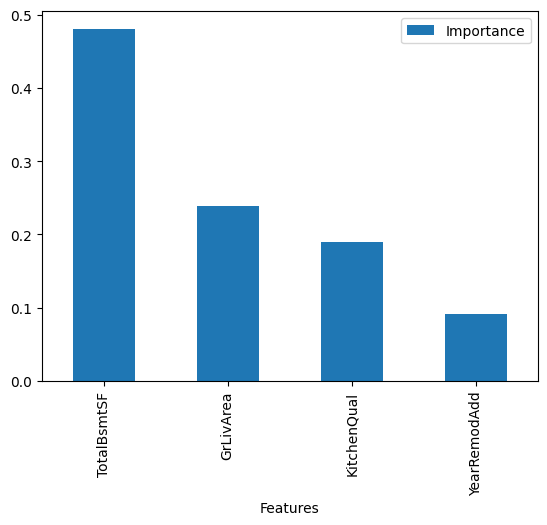

In [26]:
best_features_df.plot(kind='bar', x='Features', y='Importance')
plt.show()

Now we can also visually aid our comprehension of the model with scatter plots which will include the data predicted from the model. This will allow us to judge at a glance the behavior of the model.

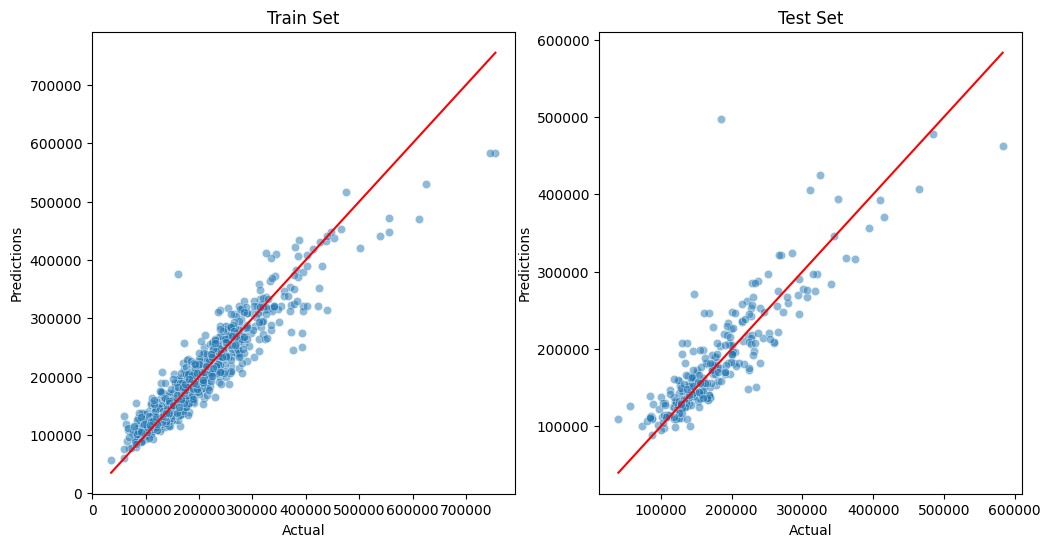

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [29]:
# This function was taken from the Churnometer Walkthrough project.

def model_scatterplots(X_train, y_train, X_test, y_test, pipeline):
    test_prediction = pipeline.predict(X_test)
    train_prediction = pipeline.predict(X_train)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=train_prediction, alpha=0.5, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=test_prediction, alpha=0.5, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.savefig('/workspaces/Fabrizio-Project-Five/outputs/ml_pipeline/predict_saleprice/model_performance.png')
    plt.show()
model_scatterplots(X_train, y_train, X_test, y_test, regressor_pipeline)

Now we can ask "would our model performance change if we fit the model with only the most relevant features?"
Let's try to answer that in the next cells.

This below is our dataset filtered to only contain the best features found by the model

In [28]:
df_best_features = df_fe.filter(best_features_df['Features'])
df_best_features['SalePrice'] = y
df_best_features

,TotalBsmtSF,GrLivArea,KitchenQual,YearRemodAdd,SalePrice
0,856,1710,Gd,2003,208500
1,1262,1262,TA,1976,181500
2,920,1786,Gd,2002,223500
3,756,1717,Gd,1970,140000
4,1145,2198,Gd,2000,250000
...,...,...,...,...,...
1374,953,1647,TA,2000,175000
1375,1542,2073,TA,1988,210000
1376,1152,2340,Gd,2006,266500
1377,1078,1078,Gd,1996,142125


Now what we want to do is to refit this dataset to the pipeline. The steps we'll follow are the following:

- Recreate the pipeline deleting the steps that were in charge of feature selection
- Split this new dataset into Train and Test set
- Fit the data to the Pipeline
- Analyze the model performance

In [29]:
# compared to the previous pipeline this one has only the feature scaler and the model step. 
def regression_pipeline(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=None)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.8, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset 
        ("feature_scaling", StandardScaler()),
        
        ("model", model),

    ])

    return pipeline_base    

In [30]:
X = df_best_features.drop('SalePrice', axis=1)
y = df_fe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1103, 4) (1103,) 
* Test set: (276, 4) (276,)


Now that we have our test and train sets we can proceed by fitting these to the model.

In [31]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [32]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
14,ExtraTreesRegressor,0.627718,0.784851,0.867002,0.088219,10,None,2,100
20,ExtraTreesRegressor,0.654575,0.784645,0.859404,0.072397,10,None,10,100
32,ExtraTreesRegressor,0.658118,0.784342,0.863264,0.071783,20,None,10,100
44,ExtraTreesRegressor,0.65774,0.78429,0.863785,0.072083,30,None,10,100
8,ExtraTreesRegressor,0.65774,0.78429,0.863785,0.072083,None,None,10,100
17,ExtraTreesRegressor,0.626735,0.783604,0.859991,0.08481,10,None,5,100
45,ExtraTreesRegressor,0.709739,0.783376,0.859705,0.052798,30,None,20,10
9,ExtraTreesRegressor,0.709739,0.783376,0.859705,0.052798,None,None,20,10
33,ExtraTreesRegressor,0.709739,0.783376,0.859705,0.052798,20,None,20,10
31,ExtraTreesRegressor,0.653734,0.782739,0.865208,0.073733,20,None,10,50


In [33]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          variables=['TotalBsmtSF', 'GrLivArea',
                                                     'KitchenQual',
                                                     'YearRemodAdd'])),
                ('feature_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, max_features=None,
                                     random_state=0))])

In [34]:
train_set_prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, train_set_prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)

r2 metric on train set:  0.954378296453676 
r2 metric on test set:  0.7068370208887165


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

As we can see from our R2 score metric the results of this new pipeline aren't satisfactory so for our dashboard we'll use the full dataset instead that the dataset with the best features.

As a final step in our notebook we can save the images for:
* The most relevant features found by our model
* The model performance plot

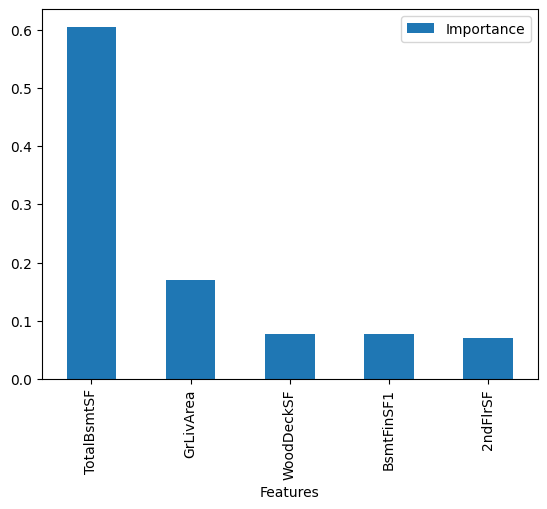

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [28]:
best_features_df.plot(kind='bar', x='Features', y='Importance')
plt.savefig(f'{filepath}/features_importance.png')